[Update Aug 2020 Mengyan Zhang]

This notebook implements regression on the first round results with repeated kfold.

# Pipeline

- Data pre-processing: run codes/data_generating.py
    - log transform 
    - z-score normalisation for each replicate (zero mean and unit variance)
- Repeated Kfold: (n_repeated: 10; n_split/kfold: 5)
    - Kernel: weighted degree kernel with shift
        - kernel normalisation: centering and unit norm
        - lmer: number of substring [3,4,5,6]
    - Gaussian process regression 
        - alpha: scalar value add to diagonal 
- Evaluation
   - metric: e.g. Mean square error; R2
   - true label: either sample or mean of sample. 

# Key Notes

## Splitting over sequences

The training and testing data should be split in terms of sequences rather than samples, since we hope to have good predictions on unseen data. Similar idea as shown in [GroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html).

## Training with multiple labels vs. sample mean?

We now training with multiple labels, i.e. repeated sequences inputs with different labels (replicates).
It worth thinking whether it is equivalent to use the sample mean directly.


## Evaluate on samples vs sample mean?

For evaluation (on both training and testing predictions), we evaluate using "samples" or "averages", indicating by "eva_on" parameter. 

## What matters

The recommendations at the end it what matters, so once we choose certain parameters, we should focus on how it changes our recommendations.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
kernel_dict = {
#     'Spectrum_Kernel': Spectrum_Kernel,
#     'Mixed_Spectrum_Kernel': Mixed_Spectrum_Kernel,
#     'WD_Kernel': WeightedDegree_Kernel,
#     'Sum_Spectrum_Kernel': Sum_Spectrum_Kernel,
    'WD_Kernel_Shift': WD_Shift_Kernel,
    'RBF': RBF
    
}

In [3]:
Path = '../../data/Results_Microplate_partialTrue_normTrue_roundRep_formatSeq_logTrue.csv'

df = pd.read_csv(Path)
df.head(20)

,idx,RBS,Name,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,...,Replicates,Plate,Round,Rep7,Rep8,Rep9,RBS6,Pred Mean,Pred Std,Pred UCB
0,648.0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,2.482263,2.555338,2.358414,3.102950,2.999178,2.316265,2.635735,...,"1,2,3,4,5,6",First_Plate,0,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
1,4096.0,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.592779,1.694296,1.798210,1.850738,2.381356,1.996343,1.885620,...,"1,2,3,4,5,6",First_Plate,0,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
2,4097.0,GTTAAGAAGGAGATATACAT,RBS_1by1_2,0.626302,0.774704,0.947196,0.418233,0.532036,0.733023,0.671916,...,"1,2,3,4,5,6",First_Plate,0,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
3,4098.0,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.696364,1.917735,1.568130,1.600853,1.803056,1.260720,1.641143,...,"1,2,3,4,5,6",First_Plate,0,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
4,4099.0,TCTAAGAAGGAGATATACAT,RBS_1by1_4,1.582321,2.118618,1.417531,2.014216,1.831391,2.186262,1.858390,...,"1,2,3,4,5,6",First_Plate,0,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
5,4100.0,TGTAAGAAGGAGATATACAT,RBS_1by1_5,0.156597,0.129608,0.447555,0.103395,0.222683,0.366914,0.237792,...,"1,2,3,4,5,6",First_Plate,0,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
6,4101.0,TATAAGAAGGAGATATACAT,RBS_1by1_6,1.296223,1.330318,0.946361,0.887157,1.269821,1.700506,1.238398,...,"1,2,3,4,5,6",First_Plate,0,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
7,4103.0,TTGAAGAAGGAGATATACAT,RBS_1by1_8,1.541914,1.703705,NaN,2.075267,1.852707,2.272039,1.889127,...,"1,2,3,4,5,6",First_Plate,0,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
8,4104.0,TTAAAGAAGGAGATATACAT,RBS_1by1_9,0.477942,0.625771,1.389786,0.385242,0.305004,0.465392,0.608190,...,"1,2,3,4,5,6",First_Plate,0,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
9,4105.0,TTTCAGAAGGAGATATACAT,RBS_1by1_10,1.505403,0.957867,0.631509,1.569340,1.254679,1.958256,1.312842,...,"1,2,3,4,5,6",First_Plate,0,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN


In [4]:
#df = df[df['Group'] != 'bps'].reset_index()
df.shape

(265, 24)

(array([19., 43., 40., 31., 38., 42., 31., 11.,  9.,  1.]),
 array([-1.73349523, -1.29657224, -0.85964925, -0.42272625,  0.01419674,
         0.45111973,  0.88804273,  1.32496572,  1.76188871,  2.19881171,
         2.6357347 ]),
 <a list of 10 Patch objects>)

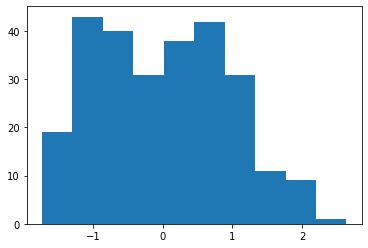

In [5]:
plt.hist(df['AVERAGE'])

# Repeated KFold 

In [6]:
kernel = 'WD_Kernel_Shift'
eva_metric = [mean_squared_error, r2_score, 'coverage rate']

gpr = GPR_Predictor(df, kernel_name = kernel)
# gpr = GPR_Predictor(df, train_idx=df['Round'] == 0, test_idx=df['Round'] == 1, kernel_name = kernel)

# num_split = 5
# num_repeat = 5
# s_list = [0,1]
# # alpha_list = [0.5]
# alpha_list= [1e-5, 1e-1, 0.5, 1, 2, 5] 
# # alpha_list= [0.01, 0.05, 0.1, 0.5].append(list(range(1,15)))
# l_list =[3,6]
# # sigma_0_list = [0.5, 1, 1.5, 2, 2.5]
# sigma_0_list = [0.5, 1, 2]

In [7]:
num_split = 5
num_repeat = 10
s_list = [1]
# alpha_list = [2]
alpha_list= [1e-5, 1e-1, 0.5, 1, 2, 5] 
# alpha_list= [0.01, 0.05, 0.1, 0.5].append(list(range(1,15)))
l_list =[6]
sigma_0_list = [0.5, 1, 1.5, 2, 2.5]
# sigma_0_list = [1]
                                                                                                         
result_DataArray = gpr.Repeated_kfold(num_split=num_split, num_repeat=num_repeat,
                                      kernel_norm_flag=[True], centering_flag=[False], unit_norm_flag= [False],
                                      alpha_list= alpha_list, l_list = l_list, s_list = s_list, sigma_0_list = sigma_0_list)

Repeated KFold Running ...


IntProgress(value=0, max=1500)

wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
6
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_cent

wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
12
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix

wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center

wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
23
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix

29
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
35
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma

wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
41
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_cen

47
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix

69
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
70
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
71
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
72
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
73
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel 

wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
105
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
106
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
107
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
108
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l

wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
140
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
141
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
142
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
143
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
144
wds

wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
160
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...

wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
166
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_ce

wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
172
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matri

wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
178
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matri

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center

wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
189
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matri

wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...

210
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
211
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
212
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
213
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
214
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load sa

wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
246
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
247
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
248
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
249
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved 

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
281
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
282
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
283
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
284
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
285
wds_l

wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
303
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matri

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
309
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_ce

wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
315
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds

wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
321
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matri

wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
327
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matri

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:487: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.07007079e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 41, 'nit': 2, 'warnflag': 2}
  ConvergenceWarning)


328
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matri

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
334
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_ce

wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
340
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l

wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
346
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matri

363
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
364
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
365
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
366
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
367
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel mat

wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
399
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
400
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
401
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
402
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved 

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
434
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
435
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
436
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
437
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel m

wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
459
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_ce

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:487: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.1707894e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 39, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


463
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matri

wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
469
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_ce

wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center

wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...

wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center

wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
499
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matri

527
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
528
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
529
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
530
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
531
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kern

wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
563
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
564
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
565
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
566
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel mat

wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
598
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
599
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
600
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kern

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center

611
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matri

wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
617
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_ce

wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...

wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
628
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matri

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center

wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...

wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
646
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matri

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
660
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
661
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
662
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
663
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved ke

695
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
696
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
697
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
698
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
699
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load sa

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
731
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
732
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
733
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
734
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_si

wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
753
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matri

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
759
wds_l6_sigma0_1_s1_ce

764
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matri

wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
770
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_

wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
776
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matri

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
782
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_ce

wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
788
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matri

wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
794
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_ce

wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
800
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
801
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
802
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
803
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved 

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
835
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
836
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
837
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
838
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kern

wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
870
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
871
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
872
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
873
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved ke

wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
901
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matri

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
907
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_ce

wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...

wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
918
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_ce

wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...

wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...

wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...

wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center

wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...

wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
969
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
970
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
971
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
972
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel m

1004
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1005
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
1006
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
1007
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
1008
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matr

wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1040
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
1041
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
1042
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
1043
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
w

wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1054
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matr

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
1060
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wd

wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
1066
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_c

wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...

wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1077
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matr

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
1083
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_c

wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1089
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matr

wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
1095
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
1106
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
1107
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
1108
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
1109
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
1110


1141
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
1142
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
1143
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
1144
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
1145
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix..

wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1177
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1178
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1179
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1180
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved 

wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1202
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matr

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
1208
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_c

wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...

1219
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_c

wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1225
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matr

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
1231
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_c

wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1237
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matr

wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
1243
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_c

wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1249
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matr

wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1279
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1280
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
1281
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
1282
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix.

1314
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1315
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
1316
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
1317
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
1318
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matr

wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1350
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matr

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
1356
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_c

wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...

wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
1367
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_c

wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1373
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matr

wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1379
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matr

wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
1385
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_

wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
1391
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_c

wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1397
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matr

wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
1418
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
1419
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
1420
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1421
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2.5_s1_center_False_unitnorm_False
Load saved kernel mat

1453
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1454
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_0.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1455
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
1456
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
1457
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kerne

wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1489
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1.5_s1_center_False_unitnorm_False
Load saved kernel matrix...
1490
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
1491
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
1492
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_2_s1_center_False_unitnorm_False
Load saved kernel matri

In [9]:
import pickle

# with open('repeated_kfold_wd_shift_round01.pickle', 'wb') as handle:
with open('repeated_kfold_RBF_round01_nokenrelNormUnique.pickle', 'wb') as handle:
    pickle.dump(result_DataArray, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('repeated_kfold_wd_shift_round01.pickle', 'rb') as handle:
with open('repeated_kfold_RBF_round01_nokenrelNormUnique.pickle', 'rb') as handle:
    result_pkl = pickle.load(handle)

In [10]:
result_pkl.loc[dict(train_test = 'Test')].loc[dict(eva_metric='coverage rate')]

<xarray.DataArray (eva_on: 2, kernel_norm_flag: 1, centering_flag: 1, unit_norm_flag: 1, alpha: 6, rbf_lengthscale: 1, l: 1, s: 1, sigma_0: 5, num_repeat: 10, num_split: 5)>
array([[[[[[[[[[[0.9677673 , 0.96852872, 0.97088906, 0.96616837,
                 0.96223446],
                [0.97403619, 0.96852872, 0.96538159, 0.9693155 ,
                 0.9677673 ],
                [0.97088906, 0.96459481, 0.96855346, 0.96616837,
                 0.96380803],
                ...,
                [0.9693155 , 0.96305031, 0.96616837, 0.96695515,
                 0.97246263],
                [0.96695515, 0.96538159, 0.96852872, 0.96540881,
                 0.97010228],
                [0.97167585, 0.97167585, 0.96855346, 0.96616837,
                 0.96852872]],

               [[0.96540881, 0.96774194, 0.96144768, 0.96144768,
                 0.96616837],
                [0.9693155 , 0.97010228, 0.96302124, 0.96302124,
                 0.96226415],
                [0.96852872, 0.96380803, 0.96462264, 0.96380803,
                 0.96616837],
...
                [0.81117231, 0.83962264, 0.82533438, 0.86782061,
                 0.82533438],
                [0.82061369, 0.85837923, 0.815893  , 0.86320755,
                 0.82061369],
                [0.78756884, 0.82533438, 0.85377358, 0.83005507,
                 0.85837923]],

               [[0.90566038, 0.87254131, 0.86782061, 0.877262  ,
                 0.90086546],
                [0.85365854, 0.88670338, 0.89142408, 0.85365854,
                 0.87735849],
                [0.877262  , 0.84893784, 0.88679245, 0.86782061,
                 0.877262  ],
                ...,
                [0.86309992, 0.86792453, 0.85837923, 0.88198269,
                 0.877262  ],
                [0.86309992, 0.89614477, 0.877262  , 0.88207547,
                 0.84893784],
                [0.83949646, 0.84421715, 0.87735849, 0.88198269,
                 0.88198269]]]]]]]]]]])
Coordinates:
    train_test        <U5 'Test'
  * eva_on            (eva_on) <U7 'samples' 'seq'
    eva_metric        <U13 'coverage rate'
  * kernel_norm_flag  (kernel_norm_flag) bool True
  * centering_flag    (centering_flag) bool False
  * unit_norm_flag    (unit_norm_flag) bool False
  * alpha             (alpha) float64 1e-05 0.1 0.5 1.0 2.0 5.0
  * rbf_lengthscale   (rbf_lengthscale) int64 1
  * l                 (l) int64 6
  * s                 (s) int64 1
  * sigma_0           (sigma_0) float64 0.5 1.0 1.5 2.0 2.5
  * num_repeat        (num_repeat) int64 0 1 2 3 4 5 6 7 8 9
  * num_split         (num_split) int64 0 1 2 3 4

In [11]:
# result_pkl[1][1][1].loc[dict(centering_flag = True)].loc[dict(unit_norm_flag = False)].mean(axis = -1).mean(axis = -1)
result_pkl[1][1][2].mean(axis = -1).mean(axis = -1)

<xarray.DataArray (kernel_norm_flag: 1, centering_flag: 1, unit_norm_flag: 1, alpha: 6, rbf_lengthscale: 1, l: 1, s: 1, sigma_0: 5)>
array([[[[[[[[0.99178718, 0.98980479, 0.99112651, 0.99178703,
              0.99244778]]]],



          [[[[0.97866618, 0.97649511, 0.97989341, 0.98187544,
              0.98263052]]]],



          [[[[0.47551764, 0.64062141, 0.73520954, 0.79505938,
              0.84197557]]]],



          [[[[0.48454767, 0.63835577, 0.7305843 , 0.78278729,
              0.83347891]]]],



          [[[[0.49455502, 0.65443582, 0.74323293, 0.79298131,
              0.83933175]]]],



          [[[[0.52164771, 0.69592432, 0.77901081, 0.83498961,
              0.87473197]]]]]]]])
Coordinates:
    train_test        <U5 'Test'
    eva_on            <U7 'seq'
    eva_metric        <U13 'coverage rate'
  * kernel_norm_flag  (kernel_norm_flag) bool True
  * centering_flag    (centering_flag) bool False
  * unit_norm_flag    (unit_norm_flag) bool False
  * alpha             (alpha) float64 1e-05 0.1 0.5 1.0 2.0 5.0
  * rbf_lengthscale   (rbf_lengthscale) int64 1
  * l                 (l) int64 6
  * s                 (s) int64 1
  * sigma_0           (sigma_0) float64 0.5 1.0 1.5 2.0 2.5

(array([13., 15., 29.,  3.,  2.,  8., 20., 37., 36., 17.]),
 array([-0.18670497, -0.05610932,  0.07448633,  0.20508198,  0.33567763,
         0.46627327,  0.59686892,  0.72746457,  0.85806022,  0.98865587,
         1.11925152]),
 <a list of 10 Patch objects>)

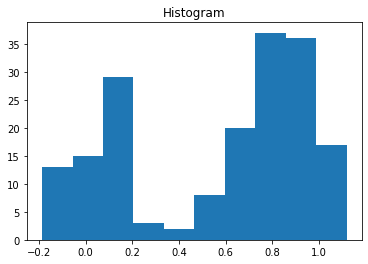

In [12]:
# result_pkl[1][1][2].loc[dict(s = 1)].loc[dict(l=6)].mean(axis = -1).mean(axis = -1).plot()
result_pkl[1].mean(axis = -1).mean(axis = -1).plot()